In [1]:
# Installation
!pip install requests --quiet
!pip install pandas --quiet
!pip install beautifulsoup4 --quiet

In [2]:
#Imports
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [3]:
#URL 
url = "https://www.fundamentus.com.br/fii_resultado.php"

In [4]:
#Header Config

headers = { 
    'User-Agent'      : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36', 
    'Accept'          : 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8', 
    'Accept-Language' : 'en-US,en;q=0.5',
    'DNT'             : '1', # Do Not Track Request Header 
    'Connection'      : 'close'
}
data = requests.get(url, headers=headers, timeout=5).text
soup = BeautifulSoup(data,"html.parser")

In [5]:
#Bind table

table = soup.find('table')

In [6]:
#Creatring DataFrame

fii_df = pd.DataFrame(columns=[
        'Papel', 
        'Segmento',
        'Cotação',
        'FFO Yield',
        'Dividend Yield',
        'P/VP',
        'Valor de Mercado',
        'Liquidez',
        'Qtd de Imóveis',
        'Preço do m2',
        'Aluguel por m2',
        'Cap Rate',
        'Vacancia Media'
    ])

In [7]:
# Getting all rows

for row in table.tbody.find_all('tr'):
    # Getting all columns 
    columns = row.find_all('td')
    if (columns != {}):
        papel = columns[0].text.strip('')
        segmento = columns[1].text.strip('')
        cotacao = columns[2].text.strip('')
        ffo_yield = columns[3].text.strip('')
        dividend_yield = columns[4].text.strip(' ')
        pvp = columns[5].text.strip(' ') 
        valor_mercado = columns[6].text.strip(' ') 
        liquidez = columns[7].text.strip(' ')
        qtd_imoveis = columns[8].text.strip(' ')
        preco_m2 = columns[9].text.strip(' ')
        aluguel_m2 = columns[10].text.strip(' ')
        cap_rate = columns[11].text.strip(' ')
        vacancia_media = columns[12].text.strip(' ')
        
        fii_df = pd.concat([fii_df, pd.DataFrame.from_records([{
            'Papel': papel, 
            'Segmento': segmento,
            'Cotação': cotacao,
            'FFO Yield': ffo_yield,
            'Dividend Yield': dividend_yield,
            'P/VP': pvp,
            'Valor de Mercado': valor_mercado,
            'Liquidez': liquidez,
            'Qtd de Imóveis': qtd_imoveis,
            'Preço do m2': preco_m2,
            'Aluguel por m2': aluguel_m2,
            'Cap Rate': cap_rate,
            'Vacancia Media': vacancia_media
        }])], ignore_index=True)

In [8]:
#Replace Dot with empty
fii_df = fii_df.applymap(lambda x: str(x.replace('.','').replace(',','.').strip('%')))

In [9]:
#Convert columns to float and integer
fii_df = fii_df.astype({
        'Cotação':'float',
        'FFO Yield':'float',
        'Dividend Yield':'float',
        'P/VP':'float',
        'Valor de Mercado':'int',
        'Liquidez':'int',
        'Qtd de Imóveis': 'int',
        'Preço do m2':'float',
        'Aluguel por m2':'float',
        'Cap Rate':'float',
        'Vacancia Media':'float'
})

In [10]:
#Including column "Pontos"
fii_df['Pontos'] = 0

In [11]:
#Filtering coloumn by value
fii_df = fii_df.loc[
    (fii_df['P/VP'].between(0.7, 1.1)) &
    (fii_df['Dividend Yield'].between(8.00, 18.00)) &
    (fii_df['Valor de Mercado'] >= 800000000)
]

In [12]:
#Calculate top FII by category
def sort_columns(col_name, is_ascending=True):
    return fii_df.sort_values(by=col_name, ascending=is_ascending)

dfs = [
    sort_columns('Dividend Yield', False),
    sort_columns('P/VP'),
    sort_columns('Liquidez', False),
    sort_columns('Valor de Mercado', False)
]

#Add 1 point for top 5 FII
for df in dfs:
    for i in range(0,5):
        df.loc[df.index[i],'Pontos'] += 1
    fii_df['Pontos'] += df['Pontos']


In [13]:
#Getting top 10 FII
top_five_fii = fii_df.sort_values(by='Pontos', ascending=False).head(10)

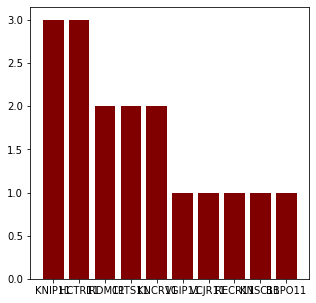

In [14]:
# Chart
chart = plt.figure(figsize=(5, 5))
plt.bar(top_five_fii.loc[:, 'Papel'], top_five_fii.loc[:, 'Pontos'], color='maroon')
plt.show()